In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s11_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((78,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 6


Create uniform log prior

In [5]:

# Define the size of the list
size = 6
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_21552/152966210.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     417     0:01.2
2     834     0:02.2
3     1200    0:03.1
20    6831    0:17.5
40    11763   0:31.0
60    16620   0:44.3
80    21318   0:56.9
100   25971   1:09.4
120   30741   1:22.3
140   35295   1:34.6
160   40155   1:47.6
180   44376   1:59.0
200   48951   2:11.3
220   53616   2:23.8
240   58257   2:36.4
260   62574   2:48.3
280   67353   3:01.3
300   71976   3:13.8
320   76731   3:26.7
340   81456   3:39.5
360   86040   3:51.8
380   90612   4:04.0
400   95295   4:16.6
420   100056   4:29.4
440   104796   4:42.1
460   109413   4:54.6
480   113913   5:06.7
500   118584   5:19.2
520   123138   5:31.3
540   127392   5:42.9
560   131796   5:54.8
580   136377   6:07.0
600   141237   6:20.0
620   145719   6:32.1
640   150117   6:43.9
660   154719   6:56.3
680   159051   7:08.0
700   163839   7:21.0
720   168435   7:33.3
740   172815   7:45.0
760   177441   7:57.

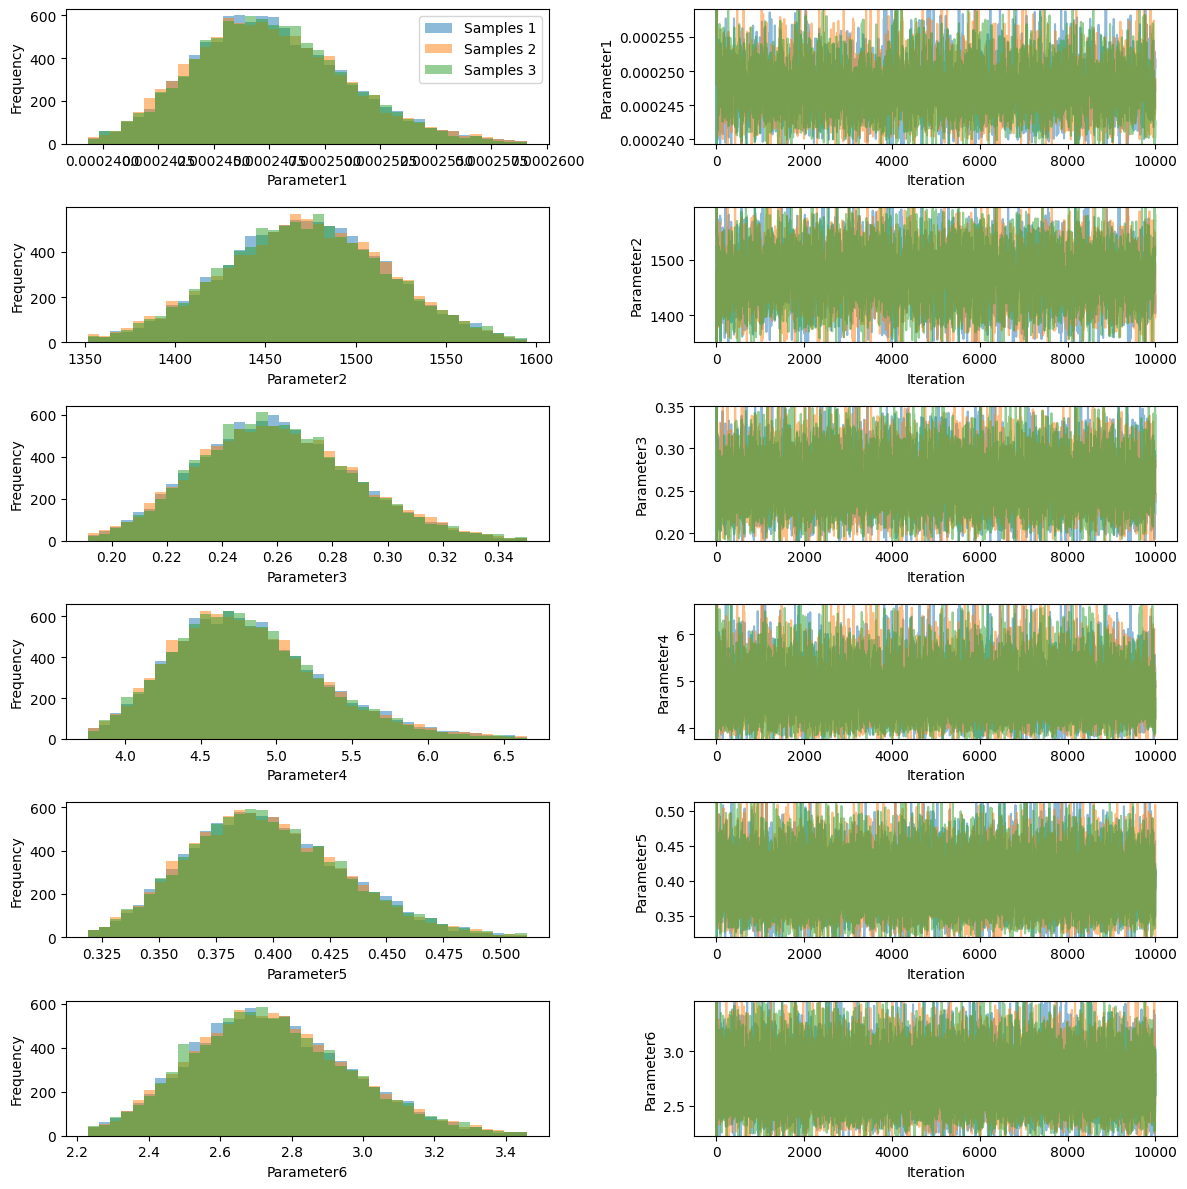

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,100:1000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 6)
[2.50862518e-04 1.41565647e+03 2.10543389e-01 4.59891567e+00
 4.30685545e-01 2.44120478e+00]
[[2.50862518e-04 1.41565647e+03 2.10543389e-01 4.59891567e+00
  4.30685545e-01 2.44120478e+00]
 [2.51111633e-04 1.42580725e+03 2.36794444e-01 5.32046463e+00
  4.48151907e-01 2.94906933e+00]
 [2.51656645e-04 1.42539298e+03 2.47469389e-01 5.18996762e+00
  4.39820152e-01 2.76029268e+00]
 ...
 [2.44473031e-04 1.53993870e+03 2.92221038e-01 4.44954353e+00
  4.00328445e-01 2.28623729e+00]
 [2.45171010e-04 1.50230792e+03 2.37828867e-01 4.76646956e+00
  3.64477891e-01 2.81472897e+00]
 [2.45134306e-04 1.49324476e+03 2.99753358e-01 4.56461139e+00
  4.15209908e-01 2.91443026e+00]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:1000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


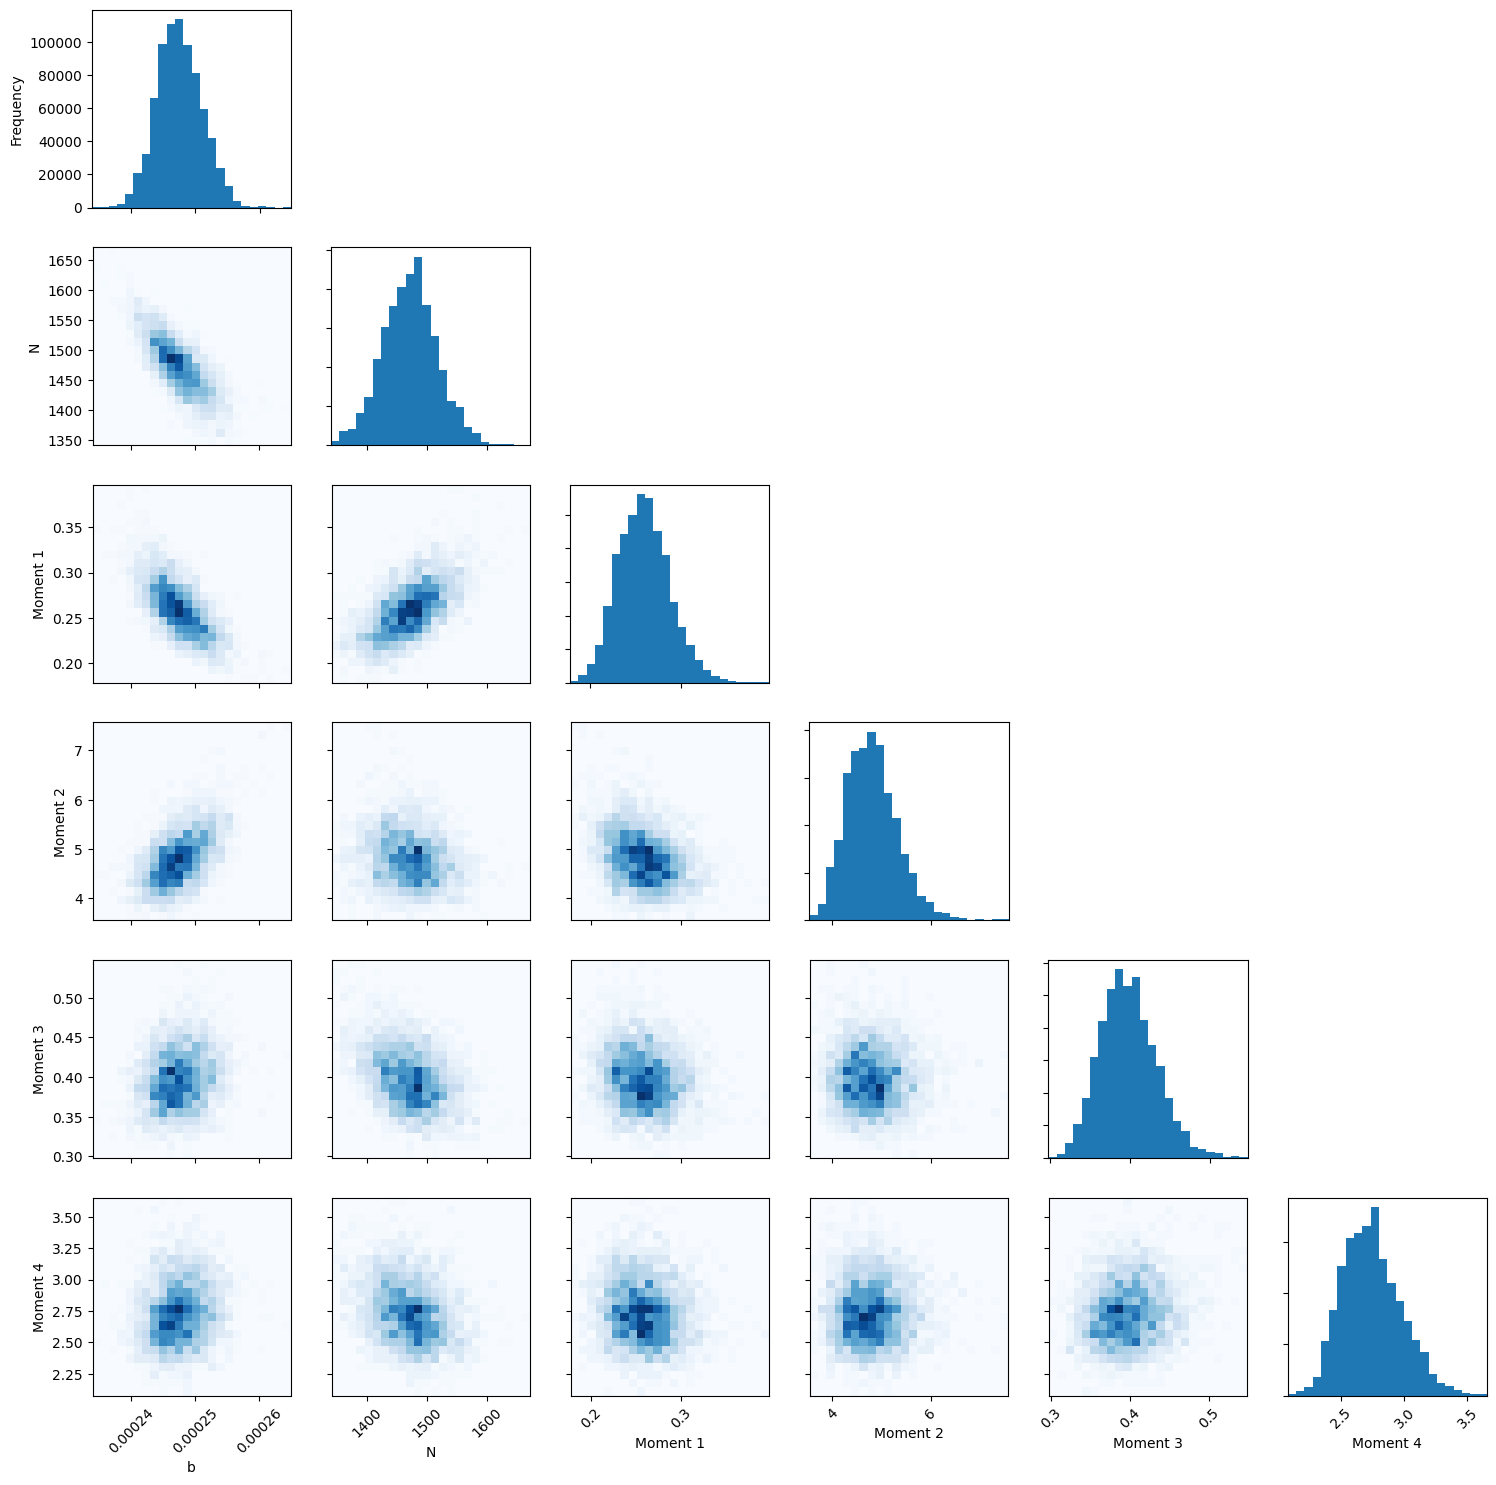

In [10]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

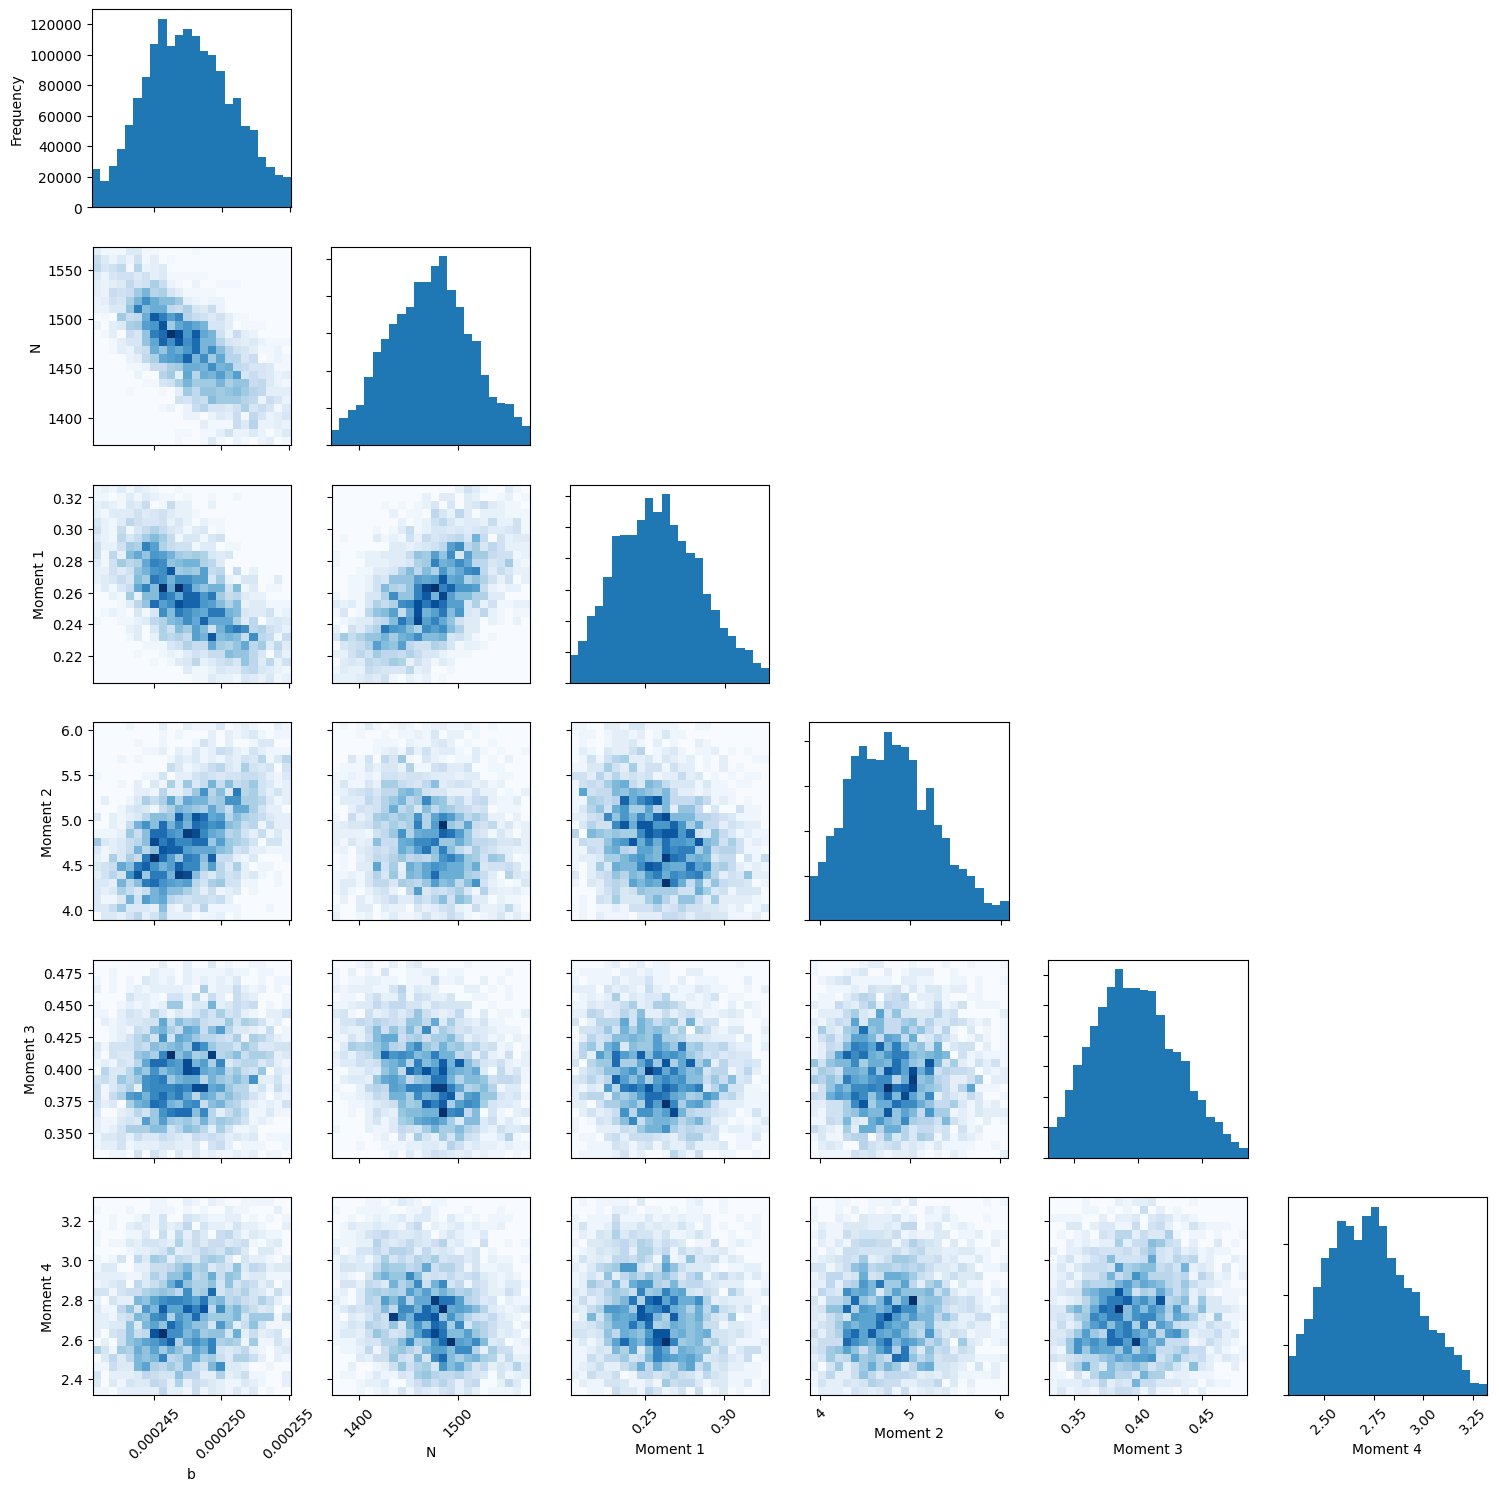

In [11]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

[2.50862518e-04 1.41565647e+03 2.10543389e-01 4.59891567e+00
 4.30685545e-01 2.44120478e+00]


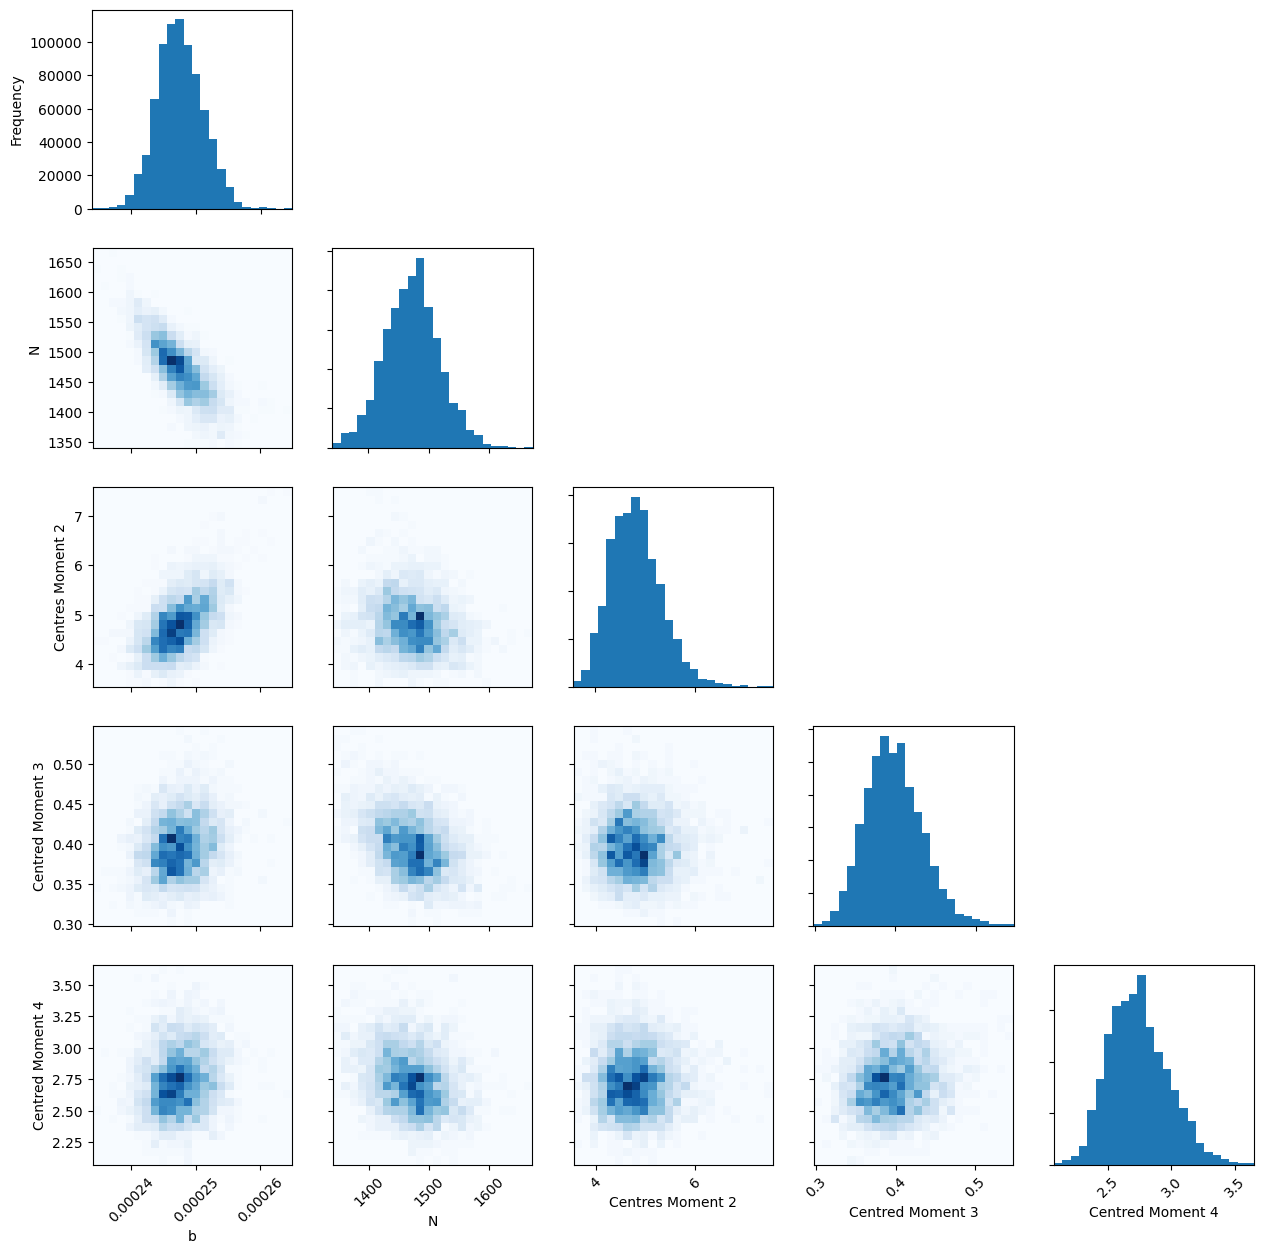

In [13]:
parameter_names = ["b","N", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3,4,5]], heatmap=True, 
                    parameter_names=["b","N", "Centres Moment 2", "Centred Moment 3", "Centred Moment 4"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [14]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess      ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  -------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    1349.56  0.19
N         1470.92  46.17   1379.95  1439.87  1470.78  1502.51  1560.95  1.00    1506.11  0.22
Moment 1  0.26     0.03    0.21     0.24     0.26     0.28     0.32     1.00    1869.52  0.27
Moment 2  4.82     0.53    3.95     4.45     4.76     5.12     6.03     1.00    2431.50  0.35
Moment 3  0.40     0.04    0.34     0.37     0.39     0.42     0.47     1.00    3884.57  0.56
Moment 4  2.75     0.23    2.34     2.59     2.73     2.89     3.24     1.00    4181.18  0.60


In [15]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [16]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%      97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  -------  --------  ------  --------  --------------
b         0.000248  3.62e-06  0.000241  0.000245  0.000247  0.00025  0.000256  1       1.35e+03  0.193
N         1.47e+03  46.2      1.38e+03  1.44e+03  1.47e+03  1.5e+03  1.56e+03  1       1.51e+03  0.216
Moment 1  0.26      0.0294    0.206     0.239     0.258     0.278    0.322     1       1.87e+03  0.268
Moment 2  4.82      0.53      3.95      4.45      4.76      5.12     6.03      1       2.43e+03  0.349
Moment 3  0.398     0.0355    0.336     0.373     0.395     0.42     0.473     1       3.88e+03  0.557
Moment 4  2.75      0.229     2.34      2.59      2.73      2.89     3.24      1       4.18e+03  0.599


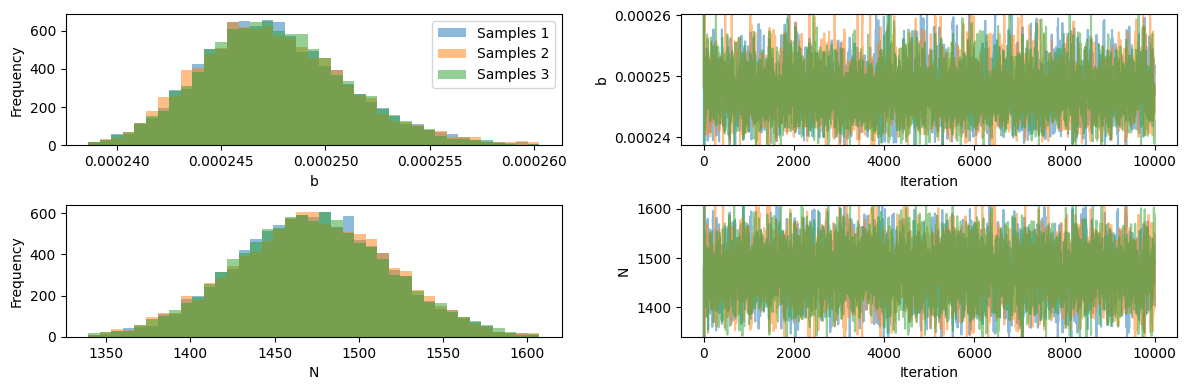

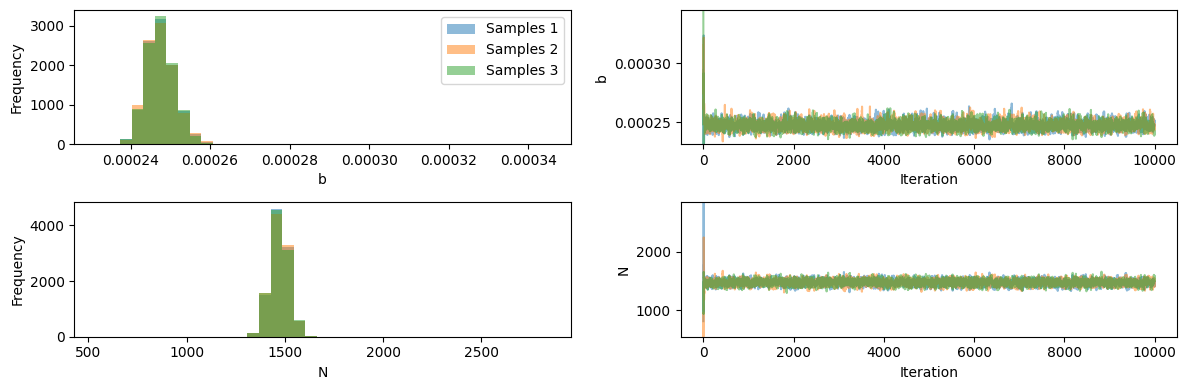

In [17]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()